<a href="https://colab.research.google.com/github/mohit1soni/DeepLearningAssignments/blob/master/Auto_Encoder_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')

In [2]:
import numpy as np
import tensorflow as tf
import sys
import os
import keras

Using TensorFlow backend.


In [0]:
logdir = os.path.join(os.getcwd(),'logs')
os.makedirs(logdir)

In [4]:
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test)=cifar10.load_data()


170500096/170498071 [==============================] - 57s 0us/step


In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 8888 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 8888 &')

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
    


In [0]:
#Defining Parameters
width = 32
height = 32
batch_size = 500
nb_epochs = 1000
code_length = 256*2


In [0]:

#Generating the tensor flow graph for the model 
graph = tf.Graph()

In [0]:
with graph.as_default():
#    Definign Global Step 
    global_step=tf.Variable(0,trainable=False)
#    Input Batch change
    input_images=tf.placeholder(tf.float32,shape=(batch_size,height,width,3))

#   Making of the convolution layer extracting features 
    conv_1=tf.layers.conv2d(input_images,filters=32,kernel_size=(3,3),
                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                            activation=tf.nn.leaky_relu,name="conv1")
#    Convolution output flattened 
    conv_out=tf.layers.flatten(conv_1,name="conv1_out")
#    Encoding Layer
    encoder=tf.layers.dense(conv_out,units=code_length,activation=tf.nn.leaky_relu,name="encoder")
#    Encoder_output layer
#  change in this line 
    encoder_out=tf.layers.dense(encoder,units=(height-2)*(width-2)*3,
                                activation=tf.nn.leaky_relu,name="encoder_out")
#    Deconvolution Layer
    deconv_input=tf.reshape(encoder_out,shape=(batch_size,height-2,width-2,3),
                                name="deconv_inp")
    deconv_1=tf.layers.conv2d_transpose(deconv_input,filters=3,
                                        kernel_size=(3,3),
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                        activation=tf.sigmoid,name="deconv1")
#    Making Output Images
    output_images=tf.cast(tf.reshape(deconv_1,(batch_size,height,width,3))*255.0,tf.uint8)
    
#    Loss consruction
    loss=tf.nn.l2_loss(input_images-deconv_1)
    decay_step=int(X_train.shape[0]/(2*batch_size))
#    Traning The Model
    learning_rate=tf.train.exponential_decay(learning_rate=0.001,
                                             global_step=global_step,
                                             decay_steps=decay_step,
                                             decay_rate=0.95,
                                             staircase=True)
    trainer=tf.train.AdamOptimizer(learning_rate)
    
    ridx1 = tf.random_uniform((),0,batch_size,dtype=tf.int32)
    img_summary = tf.summary.image('original',tf.reshape(output_images[ridx1,:,:,:],(1,width,height,3)),max_outputs=1)
    loss_summary = tf.summary.scalar('loss_summary',loss)
    lr_summary = tf.summary.scalar('lr_summary',learning_rate)
    
    summary_merged = tf.summary.merge([loss_summary,lr_summary,img_summary])
    training_step=trainer.minimize(loss,name="Trainer")


In [0]:
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
import multiprocessing
import matplotlib.pyplot as plt

In [19]:
use_gpu = True

sess = tf.InteractiveSession(graph=graph)

writer = tf.summary.FileWriter('./log')
writer.add_graph(sess.graph)
writer.flush()

tf.global_variables_initializer().run()


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
def create_batch(t, gray=False):
    X = np.zeros((batch_size, height, width, 3 if not gray else 1), dtype=np.float32)
        
    for k, image in enumerate(X_train[t:t+batch_size]):
        if gray:
            X[k, :, :, :] = rgb2gray(image)
        else:
            X[k, :, :, :] = image / 255.0
        
    return X

In [0]:
for e in range(nb_epochs):
    total_loss = 0.0
    
    for t in range(0, X_train.shape[0], batch_size):
        feed_dict = {
            input_images: create_batch(t)
        }

        _, v_loss,summary_write = sess.run([training_step, loss,summary_merged], feed_dict=feed_dict)
        total_loss += v_loss
        writer.add_summary(summary_write,e)
    
    print('Epoch {} - Total loss: {}'.format(e+1, total_loss)) 
    if e%50==0:
      print('...syncing logs with google drive...')
      ! rsync --update -raz './log' logs
    
feed_dict = {input_images: create_batch(0)}

oimages = sess.run([output_images], feed_dict=feed_dict)

fig, ax = plt.subplots(2, batch_size, figsize=(18, 3))


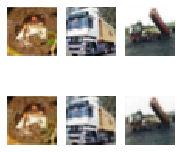

In [23]:
fig, ax = plt.subplots(2, 3, figsize=(3, 3))

for y in range(3):
    ax[0, y].get_xaxis().set_visible(False)
    ax[0, y].get_yaxis().set_visible(False)
    ax[1, y].get_xaxis().set_visible(False)
    ax[1, y].get_yaxis().set_visible(False)

    ax[0, y].imshow(X_train[y])
    ax[1, y].imshow(oimages[0][y])